# Install requirements

In [ ]:
%pip install --upgrade numpy scipy pandas

In [ ]:
%pip install --upgrade git+https://github.com/ParkhomenkoDV/substance.git@master

In [ ]:
%pip install --upgrade git+https://github.com/ParkhomenkoDV/disk.git@master

**Restart kernel!**

# Import libraries

In [1]:
from numpy import array, arange, linspace
from scipy import interpolate
import pandas as pd

In [2]:
from substance import Material
from disk import Disk

# Create material

In [3]:
material = Material('ВЖ175',  # ХН54К15МБЮВТ
                    {
                        "density": 8266,
                        "alpha": 11.8 * 10 ** -6,
                        "E": 2 * 10 ** 11,
                        "mu": 0.3,
                        "sigma_s": 1570 * 10 ** 6,
                        "sigma_1000": interpolate.interp1d([1173, 1273, 1323, 1373], 
                                                            array([313.9, 166.8, 119.7, 78.5]) * 10**6, 
                                                            kind=2, fill_value='extrapolate'),
                        "sigma_5000": interpolate.interp1d([1173, 1273, 1323, 1373], 
                                                            array([245.3, 124.6, 83.4, 49.1]) * 10**6, 
                                                            kind=2, fill_value='extrapolate'),
                        "sigma_10000": interpolate.interp1d([1173, 1273, 1323, 1373], 
                                                            array([225.6, 107.9, 68.7, 39.2]) * 10**6, 
                                                            kind=2, fill_value='extrapolate')
                    })

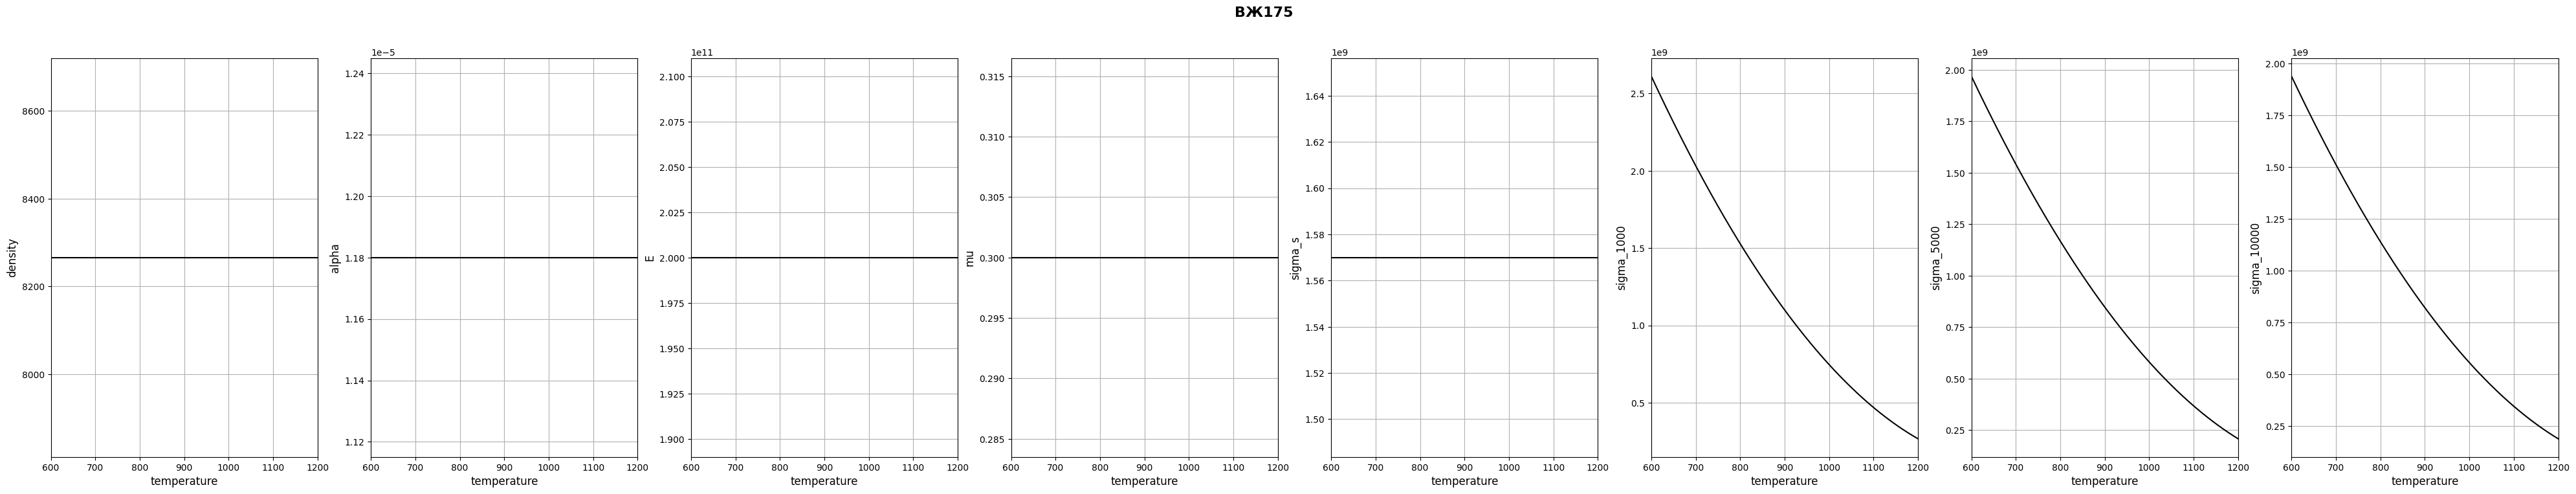

In [4]:
material.show(temperature=linspace(300, 900, 6+1) + 300, figsize=(50, 8))

# Create disk geometry

In [5]:
radius_thickness = (
    (67.50, 98.00),  # втулка диска
    (68.38, 102.24),  # радиус скругления
    (70.50, 104.00), (92.76, 104.00),  # попка диска
    (96.40, 101.55),  # радиус скругления
    (98.55, 95.19),
    (107.16, 60.71), (115.77, 43.30), (130.38, 27.30),  # радиус скругления
    (145.00, 21.86),
    (159.15, 10.43 * 2),
    (166.45, 13.23 * 2),  # радиус скругления
    (169.50, 28.00), (174.00, 28.00),  # руки диска
    (176.81, 12.63 * 2),  # радиус скругления
    (183.65, 19.16),
    (257.50, 14.00),  # горло диска
    (261.42, 14.64),  # радиус скругления
    (265.24, 16.40),  (274.04, 21.10),  # шея диска
    (276.17, 23.56),  # радиус скругления
    (277.00, 32.00), (288.00, 32.00),  # замок
)

In [6]:
radius, thickness = array(radius_thickness).T / 1000
nholes, rholes, dholes = [9], [282.5 / 1000], [6.6 / 1000]

disk = Disk(material=material,
            radius=radius, thickness=thickness,
            nholes=nholes, rholes=rholes, dholes=dholes
            )

In [7]:
pd.DataFrame({'radius': disk.radius, 'thickness': disk.thickness}) * 1000

radius  thickness
0    67.50      98.00
1    68.38     102.24
2    70.50     104.00
3    92.76     104.00
4    96.40     101.55
5    98.55      95.19
6   107.16      60.71
7   115.77      43.30
8   130.38      27.30
9   145.00      21.86
10  159.15      20.86
11  166.45      26.46
12  169.50      28.00
13  174.00      28.00
14  176.81      25.26
15  183.65      19.16
16  257.50      14.00
17  261.42      14.64
18  265.24      16.40
19  274.04      21.10
20  276.17      23.56
21  277.00      32.00
22  288.00      32.00

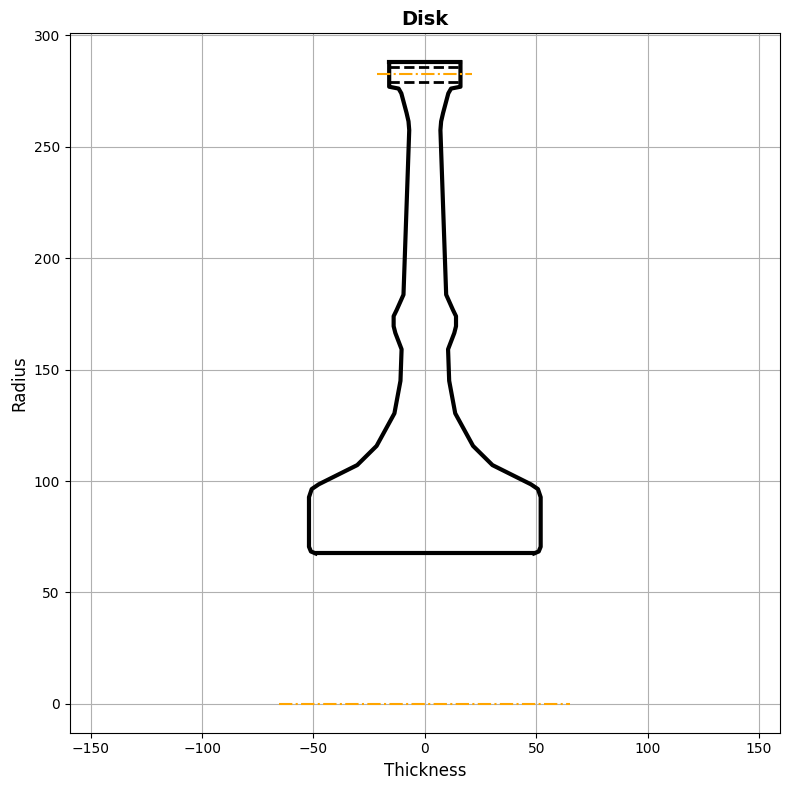

In [20]:
disk.show(figsize=(8, 8))

# Create conditions

In [9]:
rotation_frequency = 1570.8
temperature0 = 293.15
pressure = (0, 121.2 * 10 ** 6)
temperature = (550, 850)

condition = dict(rotation_frequency=rotation_frequency, 
                 temperature0=temperature0, 
                 pressure=pressure, 
                 temperature=temperature)
condition

{'rotation_frequency': 1570.8,
 'temperature0': 293.15,
 'pressure': (0, 121200000.0),
 'temperature': (550, 850)}

# Tensions

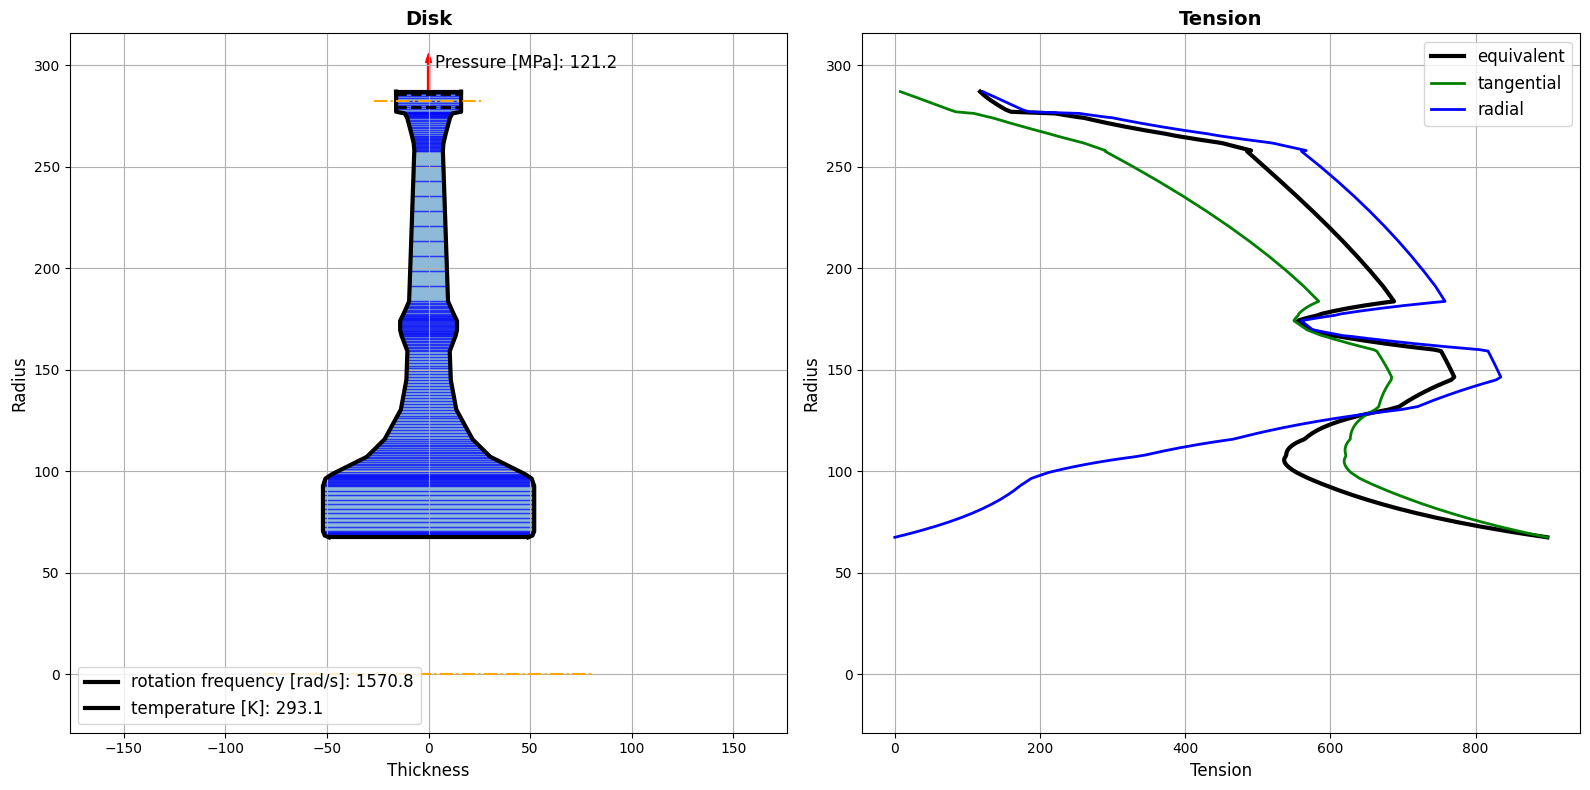

In [10]:
tensions = disk.tensions(**condition, discreteness=10, show=True)

In [11]:
f_sigma_t = interpolate.interp1d(tensions['radius'], tensions['tension_t'], kind=1)
f_sigma_r = interpolate.interp1d(tensions['radius'], tensions['tension_r'], kind=1)
for i in range(len(disk.nholes)):
    local_tension = disk.local_tension(disk.nholes[i],  disk.rholes[i], disk.dholes[i],
                                        float(f_sigma_t(disk.rholes[i])), float(f_sigma_r(disk.rholes[i])))
    print(f'holes: {i}, nholes []: {disk.nholes[i]}, rholes: {disk.rholes[i]}, dholes: {disk.dholes[i]}')
    print(f'tension_t in {local_tension}')

holes: 0, nholes []: 9, rholes: 0.2825, dholes: 0.0066
tension_t in (-28.01909266183054, -29.29268778282283)


# Design equal strength disk

In [12]:
equal_strength = disk.equal_strength(600 * 10 ** 6, condition["rotation_frequency"], max(condition['temperature']), ndis=25, show=False)

In [13]:
radius_equal_strength = linspace(0, disk.radius[-1], 10, endpoint=True)
thickness_equal_strength = equal_strength(radius_equal_strength)

disk_equal_strength = Disk(material=disk.material, radius=radius_equal_strength, thickness=thickness_equal_strength)

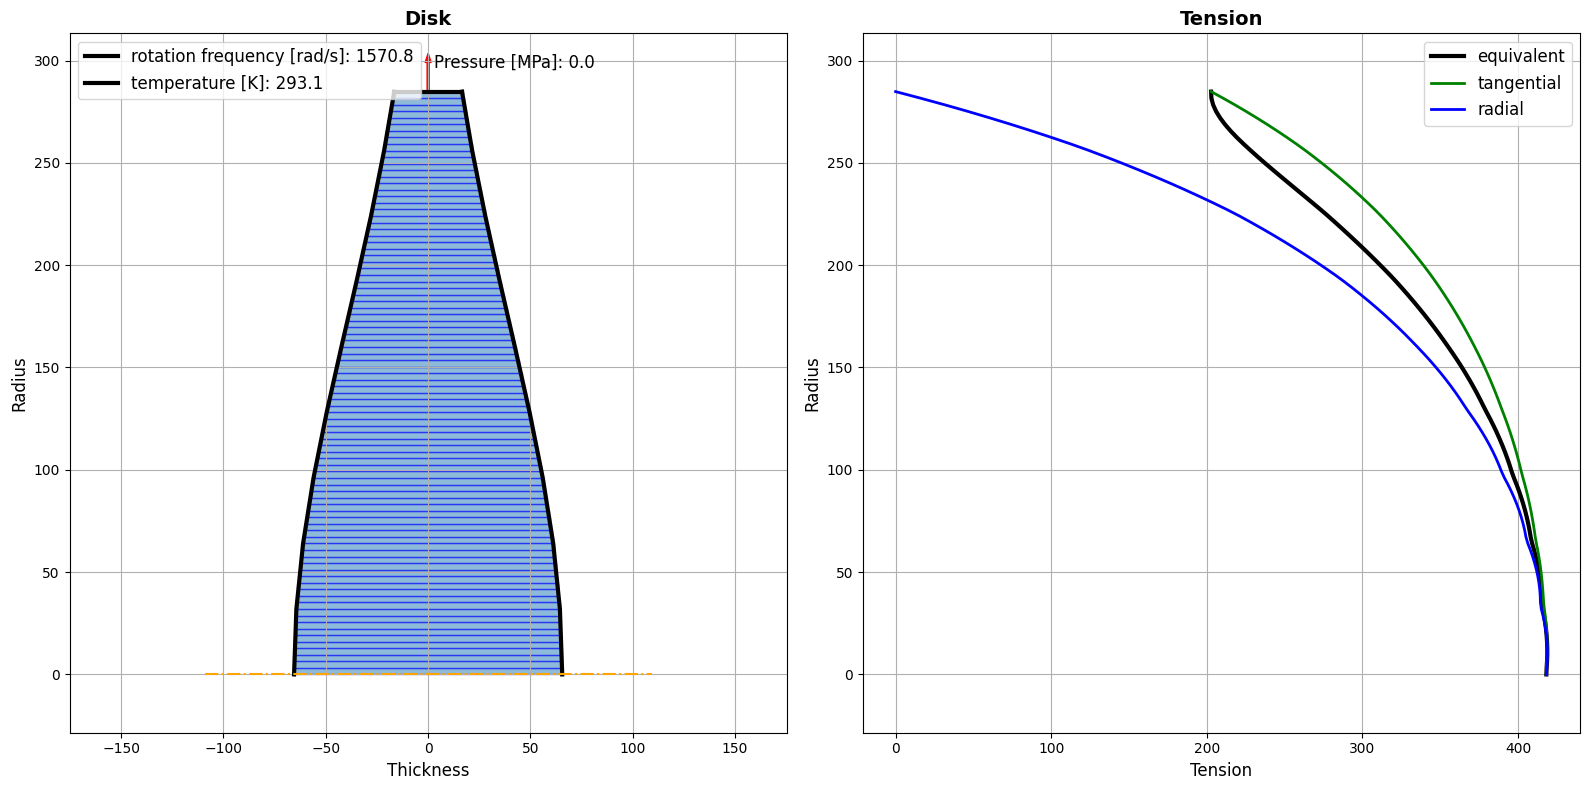

In [14]:
tensions = disk_equal_strength.tensions(rotation_frequency=condition['rotation_frequency'],
                                    temperature0=condition['temperature0'],
                                    pressure=(0, 0), temperature=(700, 700),
                                    discreteness=10, show=True)

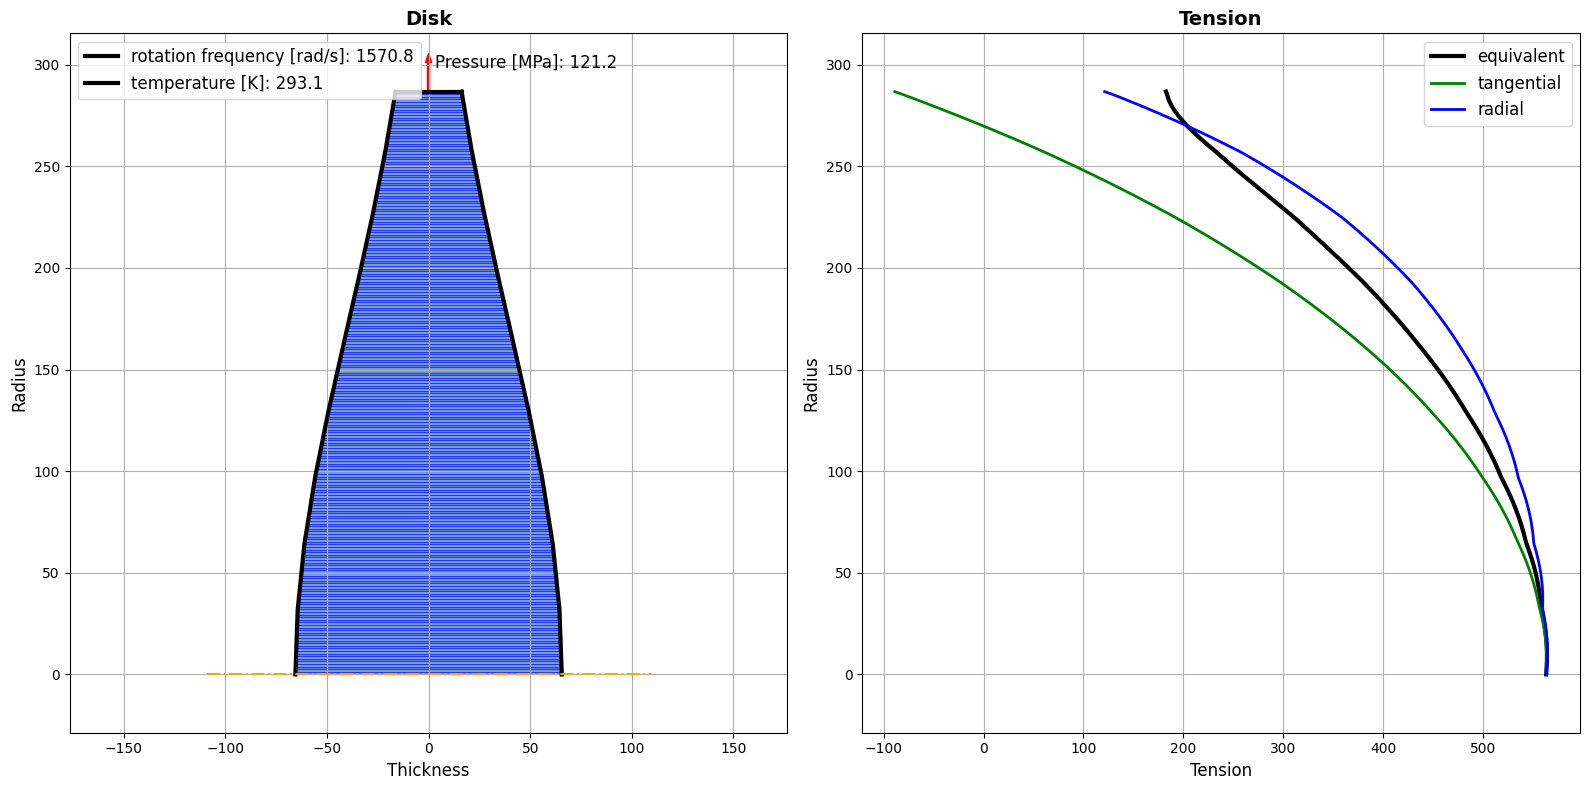

In [15]:
tensions = disk_equal_strength.tensions(**condition, discreteness=25, show=True)

In [16]:
disk.frequency_safety_factor(condition["rotation_frequency"], temperature=600, pressure=pressure)

((2.0809187012063606, 2.1965252957178247), '')

# Campbell diagram

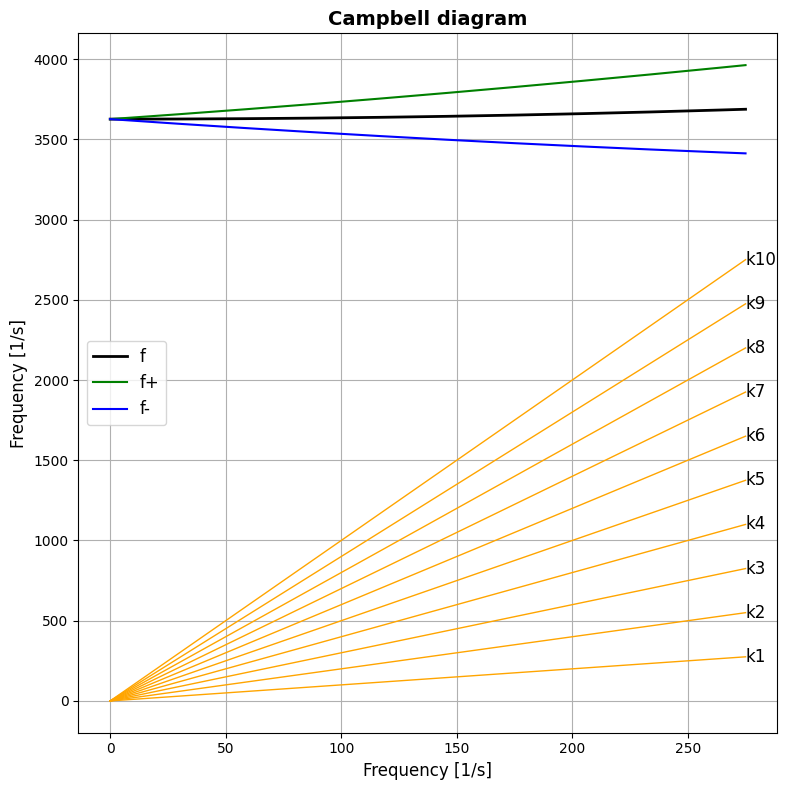

In [17]:
resonance = disk.campbell_diagram(0, 1, 1, 
                                  condition["rotation_frequency"]*1.1, 
                                  multiplicity=arange(1, 10+1, 1), )

In [18]:
resonance

((), '1/s')